# Models for XRP

1. Basalt, Granite and White Marble simulated data:
    - with appropriate substellar temperature using their albedos
    - for N_trans = 5 and N_trans = 10 
    - R = 50
2. Simulate data with Moon emissivity (see Figure 1 of [this](https://reader.elsevier.com/reader/sd/pii/S0019103597958097?token=72BDE6FFBBFCD14D9FF6FB09CA6FC0B6BC4F13CE9A40CE322394FC6F6142D74B78BA0A2CD4113AE8660BD968279266D5&originRegion=us-east-1&originCreation=20220519205422) paper), and show that a basaltic model works best

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi # THIS IS THE HOLY GRAIL OF PANDEXO
import pandexo.engine.justplotit as jpi
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import astropy
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter, NullFormatter
from scipy.ndimage import gaussian_filter1d as gauss_conv
import pickle as pk
import numpy as np
import pandas as pd
import scipy.constants as sc
from spectres import spectres 
import copy
import pysynphot as psyn

import matplotlib
#%matplotlib notebook

In [1]:
# imports for the rocky_exo environment

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import numpy as np
from spectres import spectres 
from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyutils

In [2]:
# define a function to calculate F_p/F_* at a given wavelength

def bb(wav,T):
    pi = np.pi
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity


def fp_over_fstar(wav_array,R_p, D_p, eps_array, spec_star, T_00, R_star, constant_T=False):
    
    theta_array, dtheta = np.linspace(-np.pi/2, np.pi/2,num=100, retstep=True)
    phi_array, dphi = np.linspace(-np.pi/2, np.pi/2,num=100,retstep=True)
    
    theta_mesh, phi_mesh = np.meshgrid(theta_array, phi_array)
    
    spec = np.full(wav_array.size, np.nan)
    
    for i in range(wav_array.size):
        wav = wav_array[i]
        eps = eps_array[i]
        if constant_T:
            T_mesh = T_00*np.ones(theta_mesh.shape)
        else:
            T_mesh = T_00*(np.cos(theta_mesh)*np.cos(phi_mesh))**0.25
        B_mesh = bb(wav,T_mesh)
        angles_mesh = np.cos(theta_mesh)**2*np.cos(phi_mesh)
        integral = np.sum(eps*B_mesh*angles_mesh*dtheta*dphi)
            
        spec[i] = (R_p/D_p)**2*(1 - eps + integral/(np.pi*spec_star[i]*(R_star/D_p)**2))
        
    if np.sum(np.isnan(spec)) == True:
        raise ValueError('spec has one or more nan values in it')
    else:
        return spec

## Generate models for basalt, white marble, and basalt (their emissivities have prominent features and look separate)

In [3]:
## use equilibrium temperature as an approximation of substellar temperatures for basalt, white marble and basalt

T_star = 3036    # stellar temperature in K
R_p = 0.116*7.1492*10**7   # planetary radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al.
a = 7.039*R_star

A_basalt = 0. # https://tobyrsmith.github.io/Astro150/Tutorials/Spectra/
A_marble = 0.7 # https://ui.adsabs.harvard.edu/abs/2005SPIE.5886..111S/abstract
A_granite = 0.30 # https://scienceworld.wolfram.com/physics/Albedo.html

T_basalt = T_star*np.sqrt(R_star/(2*a))*(1 - A_basalt)**(0.25)
T_whitemarble = T_star*np.sqrt(R_star/(2*a))*(1 - A_marble)**(0.25)
T_granite = T_star*np.sqrt(R_star/(2*a))*(1 - A_granite)**(0.25)

In [4]:
T_basalt, T_granite, T_whitemarble

(809.1541889477488, 740.1262316326217, 598.8411014231305)

In [5]:
#### Produce planetary emission models for these three rock types

### load emissivity data

eps_basalt = np.loadtxt('data_Emily/basalt.csv', delimiter=',')
wav_basalt, eps_basalt  = eps_basalt[:,0][::-1], eps_basalt[:,1][::-1]

eps_granite = np.loadtxt('data_Emily/granite.csv', delimiter=',')
wav_granite, eps_granite = eps_granite[:,0][::-1], eps_granite[:,1][::-1]

eps_whitemarble = np.loadtxt('data_Emily/whitemarble.csv', delimiter=',')
wav_whitemarble, eps_whitemarble = eps_whitemarble[:,0][::-1], eps_whitemarble[:,1][::-1]

### define constant parameters for the model

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
#T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)
T_star = 3036    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al. 
# calculate Fp/F_star using a blackbody stellar spectrum

#### calculate models for a grid model star

star_dict = {}
star_dict['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
star_dict['temp'] = 3036            #in K
#star_dict['temp'] = 3500             # miniumum limit for pysynphot's ck04models grid
star_dict['metal'] = 0.0             # as log Fe/H (don't know this value)
star_dict['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
#star_dict['logg'] = 5.00             # maximum limit for pysynphot's ck04models grid

sp = psyn.Icat("phoenix", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
wav_stellar = sp.wave
spec_stellar = sp.flux

#### Convert everything to SI (wavelength in m and flux density in W m^-2 Hz^-1)

#slice the arrays between 1 and 25 microns

ind = np.where((wav_stellar > 1.0*10**-6) & (wav_stellar < 25.0*10**-6))
wav_stellar = wav_stellar[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
spec_stellar = spec_stellar[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
spec_stellar = spec_stellar*c/(wav_stellar)**2

spec_stellar = spec_stellar/(4*np.pi)   # convert from flux density to radiance
wav_stellar = wav_stellar*10**6   # convert to microns

stellar_fudge_factor = 4   # a fudge factor to get the stellar grid model to match the blackbody model (see the other notebook)

### Calculate basalt model

spec_stellar_grid = spectres(wav_basalt, wav_stellar, spec_stellar)
spec_basalt = fp_over_fstar(wav_basalt*10**-6, R_p, D_p, eps_basalt, stellar_fudge_factor*spec_stellar_grid, T_basalt, R_star, constant_T=True)

### Calculate white marble model

spec_stellar_grid = spectres(wav_whitemarble, wav_stellar, spec_stellar)
spec_whitemarble = fp_over_fstar(wav_whitemarble*10**-6, R_p, D_p, eps_whitemarble, stellar_fudge_factor*spec_stellar_grid, T_whitemarble, R_star, constant_T=True)

### Calculate granite model

spec_stellar_grid = spectres(wav_granite, wav_stellar, spec_stellar)
spec_granite = fp_over_fstar(wav_granite*10**-6, R_p, D_p, eps_granite, stellar_fudge_factor*spec_stellar_grid, T_granite, R_star, constant_T=True)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



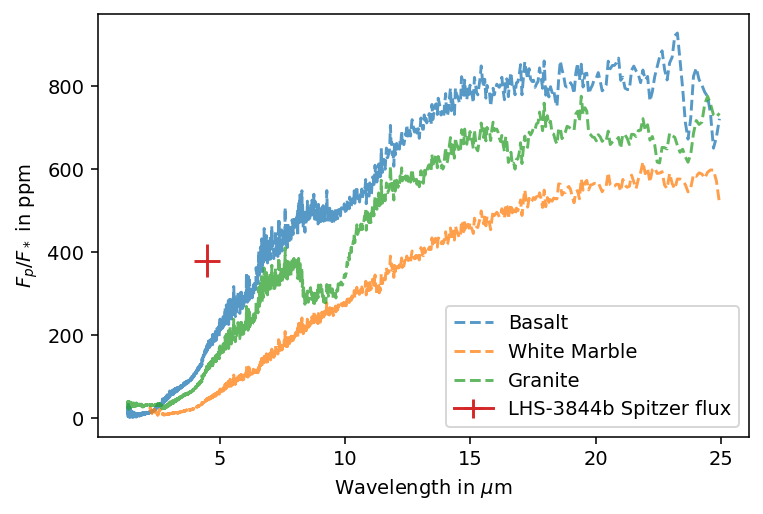

In [6]:
plt.figure()
plt.plot(wav_basalt, spec_basalt*10**6, ls='--', alpha=0.75, label='Basalt')
plt.plot(wav_whitemarble, spec_whitemarble*10**6, ls='--', alpha=0.75, label='White Marble')
plt.plot(wav_granite, spec_granite*10**6, ls='--', alpha=0.75, label='Granite')
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40,  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()

The LHS Spitzer point is way off. Need another FUDGE FACTOR to get the basalt level to match the data

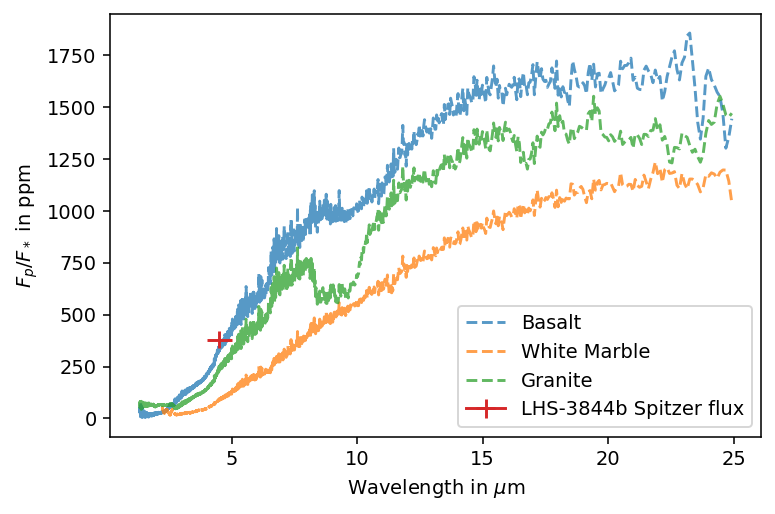

In [7]:
plt.figure()
planetary_fudge_factor = 2.0
plt.plot(wav_basalt, planetary_fudge_factor*spec_basalt*10**6, ls='--', alpha=0.75, label='Basalt')
plt.plot(wav_whitemarble, planetary_fudge_factor*spec_whitemarble*10**6, ls='--', alpha=0.75, label='White Marble')
plt.plot(wav_granite, planetary_fudge_factor*spec_granite*10**6, ls='--', alpha=0.75, label='Granite')
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40,  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()

Okay, these fudged models should work fine for now (-_-). Let's write them into files so that pandexo can use them

In [8]:
# write the model spectra into .txt files with column-1 as wavelength and column-2 as F_p/F_star

file_prefix = 'simulated_data/xrp/'
np.savetxt(file_prefix +'basalt.txt', np.array([wav_basalt, planetary_fudge_factor*spec_basalt]).T, delimiter='\t', fmt='%s')
np.savetxt(file_prefix +'whitemarble.txt', np.array([wav_whitemarble, planetary_fudge_factor*spec_whitemarble]).T, delimiter='\t', fmt='%s')
np.savetxt(file_prefix +'granite.txt', np.array([wav_granite, planetary_fudge_factor*spec_granite]).T, delimiter='\t', fmt='%s')

### Let's now run pandexo simulations for these models

In [30]:
# set up the run

exo_dict = jdi.load_exo_dict()

# exoplanet observation inputs

exo_dict['observation']['sat_level'] = 100    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 1 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

# exoplanet host star inputs

exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
exo_dict['star']['starpath'] = './simulated_data/LHS3844_stellar.dat'
exo_dict['star']['w_unit'] = 'um'                      
exo_dict['star']['f_unit'] = 'Jy'      
exo_dict['star']['mag'] = 9.1            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 2.22         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

'''
exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 3036             #in K
exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
'''

# exoplanet planetary inputs
exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'

# basalt
exo_dict_basalt = copy.deepcopy(exo_dict)
exo_dict_basalt['planet']['exopath'] = './simulated_data/xrp/basalt.txt'

# white marble
exo_dict_whitemarble = copy.deepcopy(exo_dict)
exo_dict_whitemarble['planet']['exopath'] = './simulated_data/xrp/whitemarble.txt'

# granite
exo_dict_granite = copy.deepcopy(exo_dict)
exo_dict_granite['planet']['exopath'] = './simulated_data/xrp/granite.txt'

In [31]:
# load instrument

inst_dict = jdi.load_mode_dict('MIRI LRS')

# run simulation for basalt

result = jdi.run_pandexo(exo_dict_basalt, inst_dict, output_path = './pandexo_outputs/xrp/', output_file='LHS3844b_emission_basalt.p')
result = jdi.run_pandexo(exo_dict_whitemarble, inst_dict, output_path = './pandexo_outputs/xrp/', output_file='LHS3844b_emission_whitemarble.p')
result = jdi.run_pandexo(exo_dict_granite, inst_dict, output_path = './pandexo_outputs/xrp/', output_file='LHS3844b_emission_granite.p')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


Load and plot data

In [32]:
R = 50

# load outputs from run

out_basalt = pk.load(open('./pandexo_outputs/xrp/LHS3844b_emission_basalt.p','rb'))
x_basalt_5,y_basalt_5,e_basalt_5 = jpi.jwst_1d_spec(out_basalt, R=R/2, num_tran=5, model=True, plot=False)
x_basalt_10,y_basalt_10,e_basalt_10 = jpi.jwst_1d_spec(out_basalt, R=R/2, num_tran=10, model=True, plot=False)

out_granite = pk.load(open('./pandexo_outputs/xrp/LHS3844b_emission_granite.p','rb'))
x_granite_5,y_granite_5,e_granite_5 = jpi.jwst_1d_spec(out_granite, R=R/2, num_tran=5, model=True, plot=False)
x_granite_10,y_granite_10,e_granite_10 = jpi.jwst_1d_spec(out_granite, R=R/2, num_tran=10, model=True, plot=False)

out_whitemarble = pk.load(open('./pandexo_outputs/xrp/LHS3844b_emission_whitemarble.p','rb'))
x_whitemarble_5,y_whitemarble_5,e_whitemarble_5 = jpi.jwst_1d_spec(out_whitemarble, R=R/2, num_tran=5, model=True, plot=False)
x_whitemarble_10,y_whitemarble_10,e_whitemarble_10 = jpi.jwst_1d_spec(out_whitemarble, R=R/2, num_tran=10, model=True, plot=False)

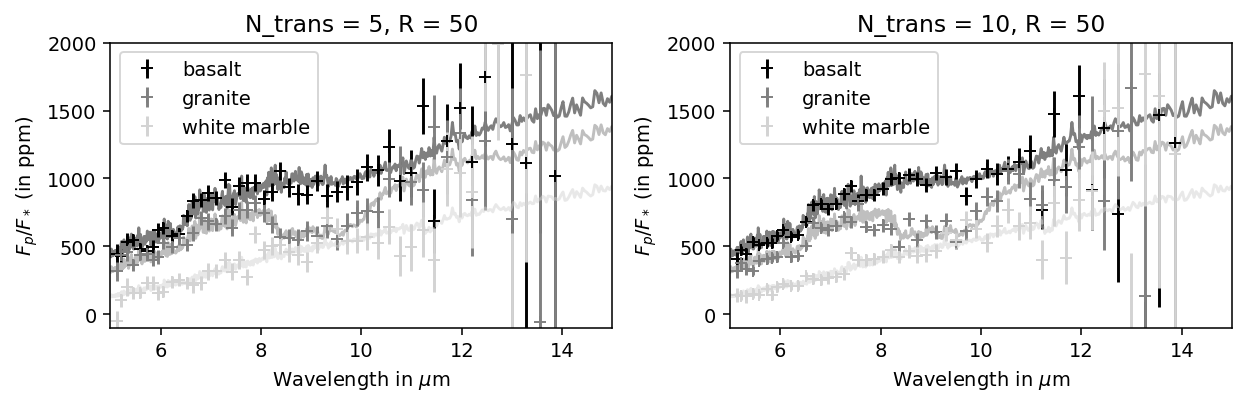

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

data = np.loadtxt(exo_dict_basalt['planet']['exopath'])
wav_basalt, spec_basalt = data[:,0], data[:,1]

data = np.loadtxt(exo_dict_whitemarble['planet']['exopath'])
wav_whitemarble, spec_whitemarble = data[:,0], data[:,1]

data = np.loadtxt(exo_dict_granite['planet']['exopath'])
wav_granite, spec_granite = data[:,0], data[:,1]

data_color_basalt= 'black'
data_color_whitemarble = 'lightgrey'
data_color_granite = 'grey'

ax[0].errorbar(x_basalt_5[0],10**6*y_basalt_5[0], yerr=10**6*e_basalt_5[0], ls='', fmt='+', label='basalt', color=data_color_basalt)
ax[0].plot(wav_basalt, 10**6*spec_basalt, color=data_color_basalt,  alpha = 0.5)
ax[0].errorbar(x_granite_5[0],10**6*y_granite_5[0], yerr=10**6*e_granite_5[0], ls='', fmt='+', label='granite', color=data_color_granite)
ax[0].plot(wav_granite, 10**6*spec_granite, color=data_color_granite,  alpha = 0.5)
ax[0].errorbar(x_whitemarble_5[0],10**6*y_whitemarble_5[0], yerr=10**6*e_whitemarble_5[0], ls='', fmt='+', label='white marble', color=data_color_whitemarble)
ax[0].plot(wav_whitemarble, 10**6*spec_whitemarble, color=data_color_whitemarble,  alpha = 0.5)
ax[0].set_ylabel('$F_p/F_*$ (in ppm)')
ax[0].set_xlabel('Wavelength in $\mu$m')
ax[0].set_xlim((5,15))
ax[0].set_ylim((-100,2000))
ax[0].set_title('N_trans = 5, R = 50')
ax[0].legend()

ax[1].errorbar(x_basalt_10[0],10**6*y_basalt_10[0], yerr=10**6*e_basalt_10[0], ls='', fmt='+', label='basalt', color=data_color_basalt)
ax[1].plot(wav_basalt, 10**6*spec_basalt, color=data_color_basalt,  alpha = 0.5)
ax[1].errorbar(x_granite_10[0],10**6*y_granite_10[0], yerr=10**6*e_granite_10[0], ls='', fmt='+', label='granite', color=data_color_granite)
ax[1].plot(wav_granite, 10**6*spec_granite, color=data_color_granite,  alpha = 0.5)
ax[1].errorbar(x_whitemarble_10[0],10**6*y_whitemarble_10[0], yerr=10**6*e_whitemarble_10[0], ls='', fmt='+', label='white marble', color=data_color_whitemarble)
ax[1].plot(wav_whitemarble, 10**6*spec_whitemarble, color=data_color_whitemarble,  alpha = 0.5)
ax[1].set_ylabel('$F_p/F_*$ (in ppm)')
ax[1].set_xlabel('Wavelength in $\mu$m')
ax[1].set_xlim((5,15))
ax[1].set_ylim((-100,2000))
ax[1].set_title('N_trans = 10, R = 50')
ax[1].legend()

plt.tight_layout()

## Now onto the Moon spectrum!

### First see if the moon emissivity is close to Emily's basalt emissivity

In [9]:
### load emissivity data

eps_moon = np.loadtxt('Resources/moon_soil_emissivity.csv', delimiter=',')
wav_moon, eps_moon  = eps_moon[:,0], eps_moon[:,1]

eps_basalt = np.loadtxt('data_Emily/basalt.csv', delimiter=',')
wav_basalt, eps_basalt  = eps_basalt[:,0][::-1], eps_basalt[:,1][::-1]

eps_granite = np.loadtxt('data_Emily/granite.csv', delimiter=',')
wav_granite, eps_granite = eps_granite[:,0][::-1], eps_granite[:,1][::-1]

eps_whitemarble = np.loadtxt('data_Emily/whitemarble.csv', delimiter=',')
wav_whitemarble, eps_whitemarble = eps_whitemarble[:,0][::-1], eps_whitemarble[:,1][::-1]

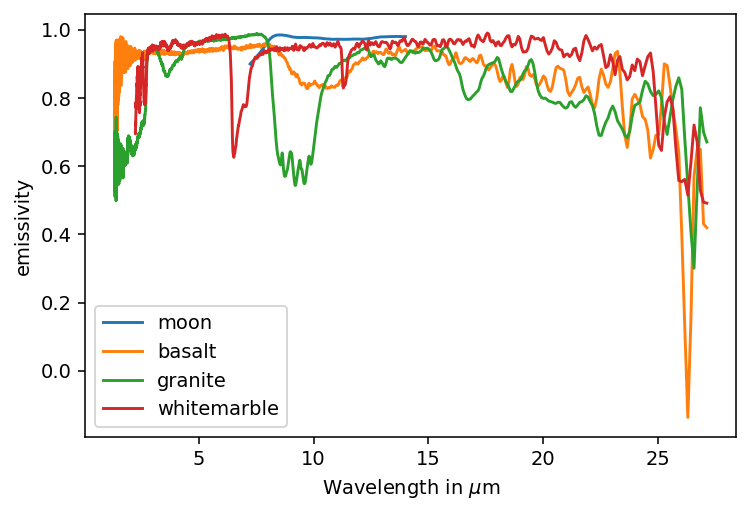

In [10]:
plt.figure()
plt.plot(wav_moon, eps_moon, label='moon')
plt.plot(wav_basalt, eps_basalt, label='basalt')
plt.plot(wav_granite, eps_granite, label='granite')
plt.plot(wav_whitemarble, eps_whitemarble, label='whitemarble')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('emissivity')
plt.legend()

### Plot LHS3844b like models for all of them and compare

In [28]:
## use equilibrium temperature as an approximation of substellar temperatures for basalt, white marble and basalt

T_star = 3036    # stellar temperature in K
R_p = 0.116*7.1492*10**7   # planetary radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al.
a = 7.039*R_star

A_basalt = 0.0 # https://tobyrsmith.github.io/Astro150/Tutorials/Spectra/
A_marble = 0.7 # https://ui.adsabs.harvard.edu/abs/2005SPIE.5886..111S/abstract
A_granite = 0.30 # https://scienceworld.wolfram.com/physics/Albedo.html
A_moon = 0.10  # https://en.wikipedia.org/wiki/Moon

T_basalt = T_star*np.sqrt(R_star/(2*a))*(1 - A_basalt)**(0.25)
T_whitemarble = T_star*np.sqrt(R_star/(2*a))*(1 - A_marble)**(0.25)
T_granite = T_star*np.sqrt(R_star/(2*a))*(1 - A_granite)**(0.25)
T_moon = T_star*np.sqrt(R_star/(2*a))*(1 - A_moon)**(0.25)

In [29]:
#### Produce planetary emission models for these three rock types

### define constant parameters for the model

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
#T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)
T_star = 3036    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al. 
# calculate Fp/F_star using a blackbody stellar spectrum

#### calculate models for a grid model star

star_dict = {}
star_dict['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
star_dict['temp'] = 3036            #in K
#star_dict['temp'] = 3500             # miniumum limit for pysynphot's ck04models grid
star_dict['metal'] = 0.0             # as log Fe/H (don't know this value)
star_dict['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
#star_dict['logg'] = 5.00             # maximum limit for pysynphot's ck04models grid

sp = psyn.Icat("phoenix", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
wav_stellar = sp.wave
spec_stellar = sp.flux

#### Convert everything to SI (wavelength in m and flux density in W m^-2 Hz^-1)

#slice the arrays between 1 and 25 microns

ind = np.where((wav_stellar > 1.0*10**-6) & (wav_stellar < 25.0*10**-6))
wav_stellar = wav_stellar[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
spec_stellar = spec_stellar[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
spec_stellar = spec_stellar*c/(wav_stellar)**2

spec_stellar = spec_stellar/(4*np.pi)   # convert from flux density to radiance
wav_stellar = wav_stellar*10**6   # convert to microns

stellar_fudge_factor = 4   # a fudge factor to get the stellar grid model to match the blackbody model (see the other notebook)

### Calculate moon model

spec_stellar_grid = spectres(wav_moon, wav_stellar, spec_stellar)
spec_moon = fp_over_fstar(wav_moon*10**-6, R_p, D_p, eps_moon, stellar_fudge_factor*spec_stellar_grid, T_moon, R_star, constant_T=True)

### Calculate basalt model

spec_stellar_grid = spectres(wav_basalt, wav_stellar, spec_stellar)
spec_basalt = fp_over_fstar(wav_basalt*10**-6, R_p, D_p, eps_basalt, stellar_fudge_factor*spec_stellar_grid, T_basalt, R_star, constant_T=True)

### Calculate white marble model

spec_stellar_grid = spectres(wav_whitemarble, wav_stellar, spec_stellar)
spec_whitemarble = fp_over_fstar(wav_whitemarble*10**-6, R_p, D_p, eps_whitemarble, stellar_fudge_factor*spec_stellar_grid, T_whitemarble, R_star, constant_T=True)

### Calculate granite model

spec_stellar_grid = spectres(wav_granite, wav_stellar, spec_stellar)
spec_granite = fp_over_fstar(wav_granite*10**-6, R_p, D_p, eps_granite, stellar_fudge_factor*spec_stellar_grid, T_granite, R_star, constant_T=True)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



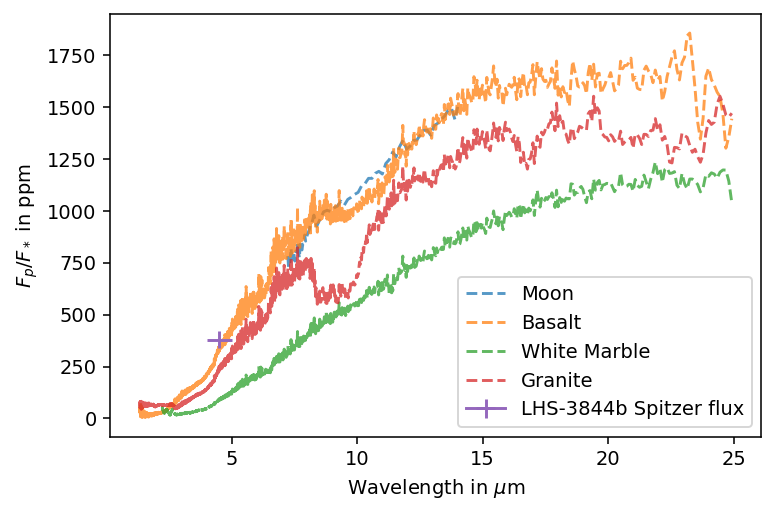

In [30]:
plt.figure()
planetary_fudge_factor = 2.0
plt.plot(wav_moon, planetary_fudge_factor*spec_moon*10**6, ls='--', alpha=0.75, label='Moon')
plt.plot(wav_basalt, planetary_fudge_factor*spec_basalt*10**6, ls='--', alpha=0.75, label='Basalt')
plt.plot(wav_whitemarble, planetary_fudge_factor*spec_whitemarble*10**6, ls='--', alpha=0.75, label='White Marble')
plt.plot(wav_granite, planetary_fudge_factor*spec_granite*10**6, ls='--', alpha=0.75, label='Granite')
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40,  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend(loc='lower right')

Okay, the moon model, using Moon's albedo of 0.13 (which is very close to basalt), matches decently well with the basalt model, although primarily because their albedos are similar. But again, it was never going to exactly fit that feature because the Moon data we are using is of a soil sample that according to the paper is a 'high titanium mare soil'. Soils are complicated, so an exact match with a pure basalt was never going to happen. 

### Now produce data using the Moon model and overplot the basalt model to it

In [31]:
# write the moon model spectrum into .txt files with column-1 as wavelength and column-2 as F_p/F_star

file_prefix = 'simulated_data/xrp/'
np.savetxt(file_prefix +'moon.txt', np.array([wav_moon, planetary_fudge_factor*spec_moon]).T, delimiter='\t', fmt='%s')

In [32]:
# set up the run

exo_dict = jdi.load_exo_dict()

# exoplanet observation inputs

exo_dict['observation']['sat_level'] = 100    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 1 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

# exoplanet host star inputs

exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
exo_dict['star']['starpath'] = './simulated_data/LHS3844_stellar.dat'
exo_dict['star']['w_unit'] = 'um'                      
exo_dict['star']['f_unit'] = 'Jy'      
exo_dict['star']['mag'] = 9.1            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 2.22         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

'''
exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 3036             #in K
exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
'''

# exoplanet planetary inputs
exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'

# moon
exo_dict['planet']['exopath'] = './simulated_data/xrp/moon.txt'

In [33]:
# load instrument

inst_dict = jdi.load_mode_dict('MIRI LRS')

# run simulation for basalt

result = jdi.run_pandexo(exo_dict, inst_dict, output_path = './pandexo_outputs/xrp/', output_file='LHS3844b_emission_moon.p')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


In [49]:
R = 50

# load outputs from run

out_moon = pk.load(open('./pandexo_outputs/xrp/LHS3844b_emission_moon.p','rb'))
x_moon_5,y_moon_5,e_moon_5 = jpi.jwst_1d_spec(out_moon, R=R/2, num_tran=5, model=True, plot=False)
x_moon_10,y_moon_10,e_moon_10 = jpi.jwst_1d_spec(out_moon, R=R/2, num_tran=10, model=True, plot=False)

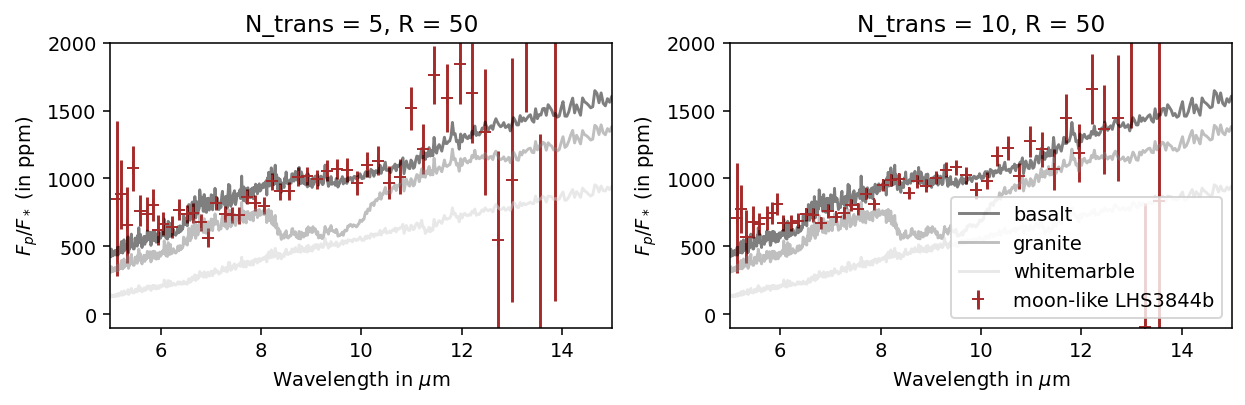

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

data = np.loadtxt('./simulated_data/xrp/basalt.txt')
wav_basalt, spec_basalt = data[:,0], data[:,1]

data = np.loadtxt('./simulated_data/xrp/whitemarble.txt')
wav_whitemarble, spec_whitemarble = data[:,0], data[:,1]

data = np.loadtxt('./simulated_data/xrp/granite.txt')
wav_granite, spec_granite = data[:,0], data[:,1]

color_basalt= 'black'
color_whitemarble = 'lightgrey'
color_granite = 'grey'

ax[0].errorbar(x_moon_5[0],10**6*y_moon_5[0], yerr=10**6*e_moon_5[0], ls='', fmt='+', label='moon-like LHS3844b', color='brown')
ax[0].plot(wav_basalt, 10**6*spec_basalt, color=color_basalt,  alpha = 0.5, label='basalt')
ax[0].plot(wav_granite, 10**6*spec_granite, color=color_granite,  alpha = 0.5, label='granite')
ax[0].plot(wav_whitemarble, 10**6*spec_whitemarble, color=color_whitemarble,  alpha = 0.5, label='whitemarble')
ax[0].set_ylabel('$F_p/F_*$ (in ppm)')
ax[0].set_xlabel('Wavelength in $\mu$m')
ax[0].set_xlim((5,15))
ax[0].set_ylim((-100,2000))
ax[0].set_title('N_trans = 5, R = 50')
#ax[0].legend(loc='lower right')

ax[1].errorbar(x_moon_10[0],10**6*y_moon_10[0], yerr=10**6*e_moon_10[0], ls='', fmt='+', label='moon-like LHS3844b', color='brown')
ax[1].plot(wav_basalt, 10**6*spec_basalt, color=color_basalt,  alpha = 0.5, label='basalt')
ax[1].plot(wav_granite, 10**6*spec_granite, color=color_granite,  alpha = 0.5, label='granite')
ax[1].plot(wav_whitemarble, 10**6*spec_whitemarble, color=color_whitemarble,  alpha = 0.5, label='whitemarble')
ax[1].set_ylabel('$F_p/F_*$ (in ppm)')
ax[1].set_xlabel('Wavelength in $\mu$m')
ax[1].set_xlim((5,15))
ax[1].set_ylim((-100,2000))
ax[1].set_title('N_trans = 10, R = 50')
ax[1].legend(loc='lower right')

plt.tight_layout()

Basalt is clearly preferred. How well are the granite and whitemarble models rejected?


In [37]:
# calculate average noise level of the moon data between 8 and 10 microns

ind = np.where((x_moon_5[0] > 8) & (x_moon_5[0] < 10))
avg_noise_5 = np.mean(10**6*e_moon_5[0][ind])


ind = np.where((x_moon_10[0] > 8) & (x_moon_10[0] < 10))
avg_noise_10 = np.mean(10**6*e_moon_10[0][ind])

# calculate average flux levels of granite and white marble models between 8 and 10 microns

ind = np.where((wav_granite > 8) & (wav_granite < 10))
avg_flux_granite = np.mean(10**6*spec_granite[ind])

ind = np.where((wav_whitemarble > 8) & (wav_whitemarble < 10))
avg_flux_whitemarble = np.mean(10**6*spec_whitemarble[ind])

ind = np.where((wav_basalt > 8) & (wav_basalt < 10))
avg_flux_basalt = np.mean(10**6*spec_basalt[ind])

print('For N_trans = 5:')
print('Granite model rejected at ', (avg_flux_basalt - avg_flux_granite)/avg_noise_5, ' sigma level')
print('Whitemarble model rejected at ', (avg_flux_basalt - avg_flux_whitemarble)/avg_noise_5, ' sigma level')

print('For N_trans = 10:')
print('Granite model rejected at ', (avg_flux_basalt - avg_flux_granite)/avg_noise_10, ' sigma level')
print('Whitemarble model rejected at ', (avg_flux_basalt - avg_flux_whitemarble)/avg_noise_10, ' sigma level')

For N_trans = 5:
Granite model rejected at  4.9710417536971  sigma level
Whitemarble model rejected at  7.000065833375945  sigma level
For N_trans = 10:
Granite model rejected at  7.030114667201373  sigma level
Whitemarble model rejected at  9.899588039064783  sigma level


### Can we do a simple Bayesian model comparison kind of analysis?

Perhaps we can do a linear mixture of the three mineral types shown above and evaluate the evidence of each

In [2]:
# save the moon-like-planet's data

np.savetxt('simulated_data/LHS3844b_moon_Ntrans_5_data.txt', np.array([x_moon_5[0],y_moon_5[0],e_moon_5[0]]).T, delimiter='\t', fmt='%s')
np.savetxt('simulated_data/LHS3844b_moon_Ntrans_10_data.txt', np.array([x_moon_10[0],y_moon_10[0],e_moon_10[0]]).T, delimiter='\t', fmt='%s')



NameError: name 'x_moon_5' is not defined

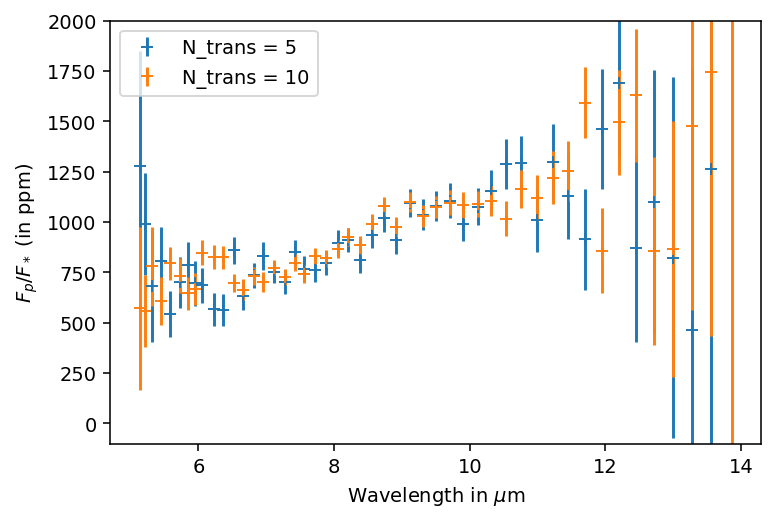

In [3]:
# load and plot data to verify

data = np.loadtxt('simulated_data/LHS3844b_moon_Ntrans_5_data.txt')
wav_moon_5, data_moon_5, err_moon_5 = data[:,0], data[:,1], data[:,2]

data = np.loadtxt('simulated_data/LHS3844b_moon_Ntrans_10_data.txt')
wav_moon_10, data_moon_10, err_moon_10 = data[:,0], data[:,1], data[:,2]

plt.plot()
plt.errorbar(wav_moon_5, 10**6*data_moon_5, yerr=10**6*err_moon_5, ls='', fmt='+', label='N_trans = 5')
plt.errorbar(wav_moon_10, 10**6*data_moon_10, yerr=10**6*err_moon_10, ls='', fmt='+', label='N_trans = 10')
plt.ylabel('$F_p/F_*$ (in ppm)')
plt.xlabel('Wavelength in $\mu$m')
plt.ylim((-100,2000))
plt.legend()


Cool. Now, let's write the dynesty functions

First, for the N_trans=10 case

In [9]:
# load the three mineral models

data = np.loadtxt('./simulated_data/xrp/basalt.txt')
wav_basalt, spec_basalt = data[:,0], data[:,1]

data = np.loadtxt('./simulated_data/xrp/whitemarble.txt')
wav_whitemarble, spec_whitemarble = data[:,0], data[:,1]

data = np.loadtxt('./simulated_data/xrp/granite.txt')
wav_granite, spec_granite = data[:,0], data[:,1]

# get them all to the same wavelength axes

spec_basalt = spectres(wav_whitemarble, wav_basalt, spec_basalt)
spec_granite = spectres(wav_whitemarble, wav_granite, spec_granite)

wav_basalt = np.copy(wav_whitemarble)
wav_granite = np.copy(wav_whitemarble)

In [5]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_moon_5)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_basalt, f_granite = theta[0], theta[1]
    f_whitemarble = 1 - (f_basalt + f_granite)

    # calculate the total spectrum as the linear sum

    spec_total = f_basalt*spec_basalt + f_granite*spec_granite + f_whitemarble*spec_whitemarble

    # bin total spectrum to data array

    spec_total = spectres(wav_moon_5, wav_basalt, spec_total)
    
    chisq = -0.5*np.sum((spec_total-data_moon_5)**2/(err_moon_5)**2)

    return chisq + norm_log



Run dynesty retrieval (Note: change conda environment to `rocky_exo`, which has dynesty installed)

In [6]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 3        # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)

sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

Exception while calling loglikelihood function:
  params: [0.25520368 0.40404273 0.26279006]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/ishanm94/miniconda3/envs/europa_research/lib/python3.8/site-packages/dynesty/dynesty.py", line 982, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_2931/385885825.py", line 23, in loglik
    spec_total = f_basalt*spec_basalt + f_granite*spec_granite + f_whitemarble*spec_whitemarble
ValueError: operands could not be broadcast together with shapes (3698,) (2142,) 


ValueError: operands could not be broadcast together with shapes (3698,) (2142,) 